<a href="https://colab.research.google.com/github/nickocruzm/Research299/blob/main/Research299.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers==0.32.2
!pip install transformers==4.49

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 105.2 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.35.1
    Uninstalling diffusers-0.35.1:
      Successfully uninstalled diffusers-0.35.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.0
    Uninstalling transformers-4.57.0:
      Successfully uninstalled transformers-4.57.0


## Pipeline 0

In [2]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
import warnings
from google.colab import userdata

warnings.simplefilter(action='ignore', category=FutureWarning)
userdata.get('HF_TOKEN')


if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f'device: {device}')

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to(device)

device: cuda


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

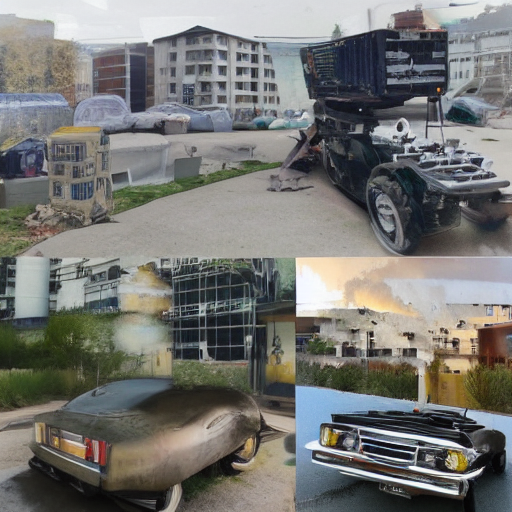

In [5]:
# Using Pipeline 0
prompt = "a bird"
image = pipe(prompt).images[0]

image

## Pipeline 1

In [4]:
import torch
import torch.nn.functional as F
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    StableDiffusionPipeline
)
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import gc



torch.cuda.empty_cache()
gc.collect()

# Device setup
def setup_device():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    print(f'device: {device}')
    return device


device = setup_device()




# 1. Load pretrained components (Stable Diffusion v1.5)

model_id = "runwayml/stable-diffusion-v1-5"

vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(device)
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)


# The scheduler defines how noise is added and removed
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

# 2. (Training Phase) Encode real image and add noise
# Load an image from disk (example)
img_name = "bird.png"
resized_image = Image.open(img_name).convert("RGB").resize((512, 512))
resized_image.save(f"{img_name}_resized.png")

image_tensor = torch.tensor((torch.FloatTensor(torch.ByteTensor(bytearray(resized_image.tobytes())).view(512, 512, 3).numpy()) / 255.0))
image_tensor = image_tensor.permute(2,0,1).unsqueeze(0).to(device)

# VAE encodes RGB → latent space
with torch.no_grad():
    latent_dist = vae.encode(image_tensor * 2 - 1).latent_dist
    latents = latent_dist.sample() * 0.18215   # scaled latent

# Encode text prompt
prompt = "a bird"
text_inputs = tokenizer(prompt, return_tensors="pt", padding="max_length",
                        max_length=tokenizer.model_max_length, truncation=True).to(device)
with torch.no_grad():
    text_embeds = text_encoder(**text_inputs).last_hidden_state


# Add noise using scheduler (forward process)
noise = torch.randn_like(latents)
timesteps = torch.randint(0, scheduler.num_train_timesteps, (1,), device=device, dtype=torch.long)
noisy_latents = scheduler.add_noise(latents, noise, timesteps)

# U-Net predicts the added noise
predicted_noise = unet(noisy_latents, timesteps, text_embeds).sample

# Compute loss (what gets optimized in training)
loss = F.mse_loss(predicted_noise, noise)
print(f"Training loss: {loss.item():.6f}")

# (In real training, you would now call loss.backward() and optimizer.step())

# ----------------------------------------------------------
# 3. (Inference Phase) Generate new image from random noise
# ----------------------------------------------------------

# You can use the pipeline for easier inference
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

prompt = "a bird"
with torch.autocast("cuda"):
    image = pipe(prompt, num_inference_steps=25, guidance_scale=7.5).images[0]

image.save(f"{img_name}_generated.png")
print("Saved generated_image.png")

device: cuda


/tmp/ipython-input-3002136591.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor((torch.FloatTensor(torch.ByteTensor(bytearray(resized_image.tobytes())).view(512, 512, 3).numpy()) / 255.0))
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Training loss: 0.205420


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Saved generated_image.png


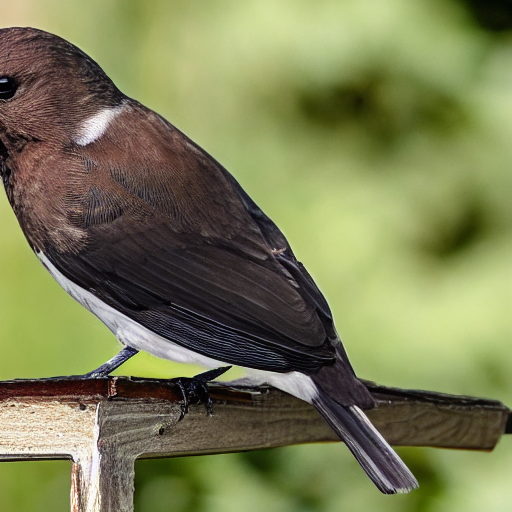

In [5]:
image

In [6]:
import torch
from diffusers import AutoencoderKL
import numpy as np

def encode_to_latent(image_np: np.ndarray, vae: AutoencoderKL, device: str = None) -> torch.Tensor:
    """
    Encode an RGB image (H,W,3) numpy array into Stable Diffusion latent space.

    Args:
        image_np (np.ndarray): Input image in [0,1] or [0,255] range, shape (H, W, 3).
        vae (AutoencoderKL): Pretrained VAE from Stable Diffusion.
        device (str, optional): 'cuda' or 'cpu'. Defaults to device of vae.

    Returns:
        torch.Tensor: Latent tensor of shape (1, 4, 64, 64).
    """
    if device is None:
        device = next(vae.parameters()).device

    # Ensure correct dtype and range
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # normalize if in [0,255]

    # Convert to tensor, permute to (B,C,H,W), and normalize to [-1,1]
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).unsqueeze(0).float().to(device)
    image_tensor = image_tensor * 2 - 1

    with torch.no_grad():
        latent_dist = vae.encode(image_tensor).latent_dist
        latents = latent_dist.sample() * 0.18215  # scale factor used in SD

    return latents

Latent shape: torch.Size([1, 4, 64, 64])


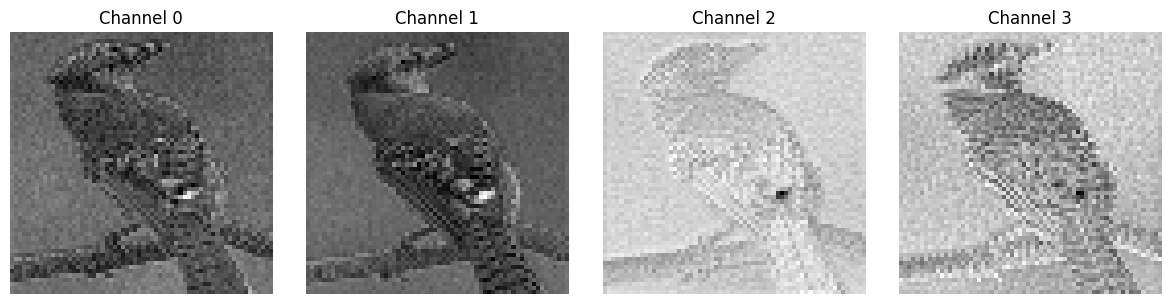

In [7]:
from diffusers import AutoencoderKL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the pretrained Stable Diffusion VAE
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to("cuda" if torch.cuda.is_available() else "cpu")

# Load image
image = Image.open("bird.png").convert("RGB").resize((512, 512))
image_np = np.array(image).astype(np.float32) / 255.0

# Get latent representation
latents = encode_to_latent(image_np, vae)
print("Latent shape:", latents.shape)

# Visualize the latent channels
latents_np = latents[0].detach().cpu().numpy()
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(latents_np[i], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Channel {i}")
plt.tight_layout()
plt.show()

## FID

FID measures how close the distribution of generated images is to the distribution of real images. A way numerically compare realism.

- FID = 0 → perfect match between real and generated distributions
- FID ≈ 5-10 → excellent for realistic models
- FID > 50 → noticeable quality gap or mode collapse

In [8]:
!pip install torch-fidelity

In [9]:
from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1="bird_generated.png",
    input2="bird.png",
    cuda=True,
    fid=True
)
print(metrics["frechet_inception_distance"])

Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:03<00:00, 27.0MB/s]
Extracting statistics from input 1


ValueError: Input descriptor "input" field can be either an instance of Dataset, GenerativeModelBase class, or a string, such as a path to a name of a registered dataset (cifar10-train, cifar10-val, stl10-train, stl10-test, stl10-unlabeled), a directory with file samples, or a path to an ONNX or PTH (JIT) module